In [1]:
######################################### NOTES ###############################################
# * Polynomial regression extends the linear model by adding extra pre-
#   dictors, obtained by raising each of the original predictors to a power.
#   For example, a cubic regression uses three variables, X, X 2 , and X 3 ,
#   as predictors. This approach provides a simple way to provide a non-
#   linear fit to data.
# * Step functions cut the range of a variable into K distinct regions in
#   order to produce a qualitative variable. This has the effect of fitting
#   a piecewise constant function.
# * Regression splines are more flexible than polynomials and step func-
#   tions, and in fact are an extension of the two. They involve dividing
#   the range of X into K distinct regions. Within each region, a poly-
#   nomial function is fit to the data. However, these polynomials are
#   constrained so that they join smoothly at the region boundaries, or
#   knots. Provided that the interval is divided into enough regions, this
#   can produce an extremely flexible fit.
# * Smoothing splines are similar to regression splines, but arise in a
#   slightly different situation. Smoothing splines result from minimizing
#   a residual sum of squares criterion subject to a smoothness penalty.
#   ****Important Note!!****
#   A smoothing spline should always be preferred to a regular spline, because
#   the number of knots in the spline is automatically controlled by the "span"
#   (the proportion of points used to compute the regression). With a low span,
#   the spline is being fit through each data point making it bumpier, while a
#   higher span will be fit through multiple proportions of the data points, where
#   the highest span goes through all data points and is equivalent to a linear fit.
# * Local regression is similar to splines, but differs in an important way.
#   The regions are allowed to overlap, and indeed they do so in a very
#   smooth way. 
#   In order to perform local regression, there are a number of choices to
#   be made, such as how to define the weighting function K, and whether
#   to fit a linear, constant, or quadratic regression. While all of these choices make some
#   difference, the most important choice is the span s, which is the proportion
#   of points used to compute the local regression at x0 (the region being fitted)
#   it controls the flexibility of the non-linear fit. The smaller the
#   value of s, the more local and wiggly will be our fit; alternatively, a very
#   large value of s will lead to a global fit to the data using all of the train-
#   ing observations. We can again use cross-validation to choose s, or we can
#   specify it directly. 
#   LOESS (or LOWESS) stands for Locally Estimated Scatterplot Smoothing
#   Local regression will go point by point, and fit a window (or span) for the nearest cluster
#   points to that specific point, and perform a weighted linear regression on just that area, and
#   then fits the new predicted point for that specific point. Then it moves through every other point
#   in the data until there is a new predicted point for each specific point. The line that is plotted
#   from those fitted points is the loess smoothed curve. The lower the window (or span), the less
#   smooth it will be. A window of 0 or will basically be connected each point together with a line,
#   whereas the highest window will be drawing a linear fit through the entire dataset.
#   The window or span can also be thought of as the proportion of the data points.
#
#
#
################################################################################################

In [2]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [3]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

weekly1["scored"] = np.where((weekly1["receiving_tds"] > 0) | (weekly1["rushing_tds"] > 0), 1, 0)
weekly1["multi_score"] = np.where(weekly1["receiving_tds"] + weekly1["rushing_tds"] > 1, 1, 0)
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]
weekly1["total_epa"] = weekly1["rushing_epa"] + weekly1["receiving_epa"]
weekly1["total_first_downs"] = weekly1["rushing_first_downs"] + weekly1["receiving_first_downs"]


try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]


model_data = weekly1[try_columns]
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
14,-0.258469,0.0,0.111111,0.0,0.66,4
15,0.662646,2.0,0.200000,3.0,0.53,5
16,-0.809390,2.0,0.166667,1.0,0.35,5
17,-0.385813,2.0,0.206897,0.0,0.47,6
18,1.970081,3.0,0.227273,3.0,0.51,10


In [91]:
# import additional
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from functools import partial
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# new modules
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split


# Model set up

X_single = model_data[["redzone"]].values
X = model_data.values
y = weekly1[["fantasy_points_ppr"]].values

In [26]:
# import additional
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from functools import partial
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# new modules
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [27]:
# Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)

y_pred = poly_reg_model.predict(poly_features)
r2_score(y, y_pred)


0.87384762574552

In [23]:
np.mean(cross_val_score(poly_reg_model, poly_features, y, cv=10))

0.8716863656285785

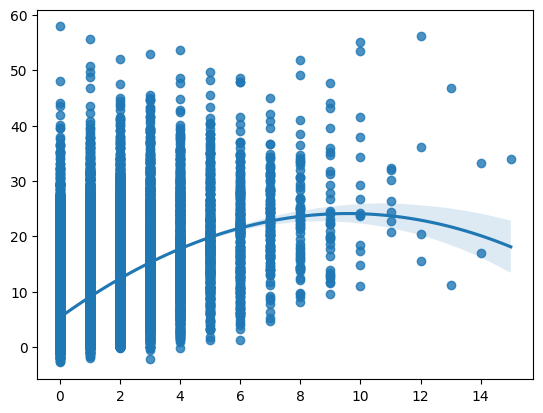

In [49]:
# Plot the regression line
fig, ax = plt.subplots()
sns.regplot(x=X_single, y=y, order=2)
plt.show()

Accuracy for Cubic Spline on testing data is :  6.494999140076891


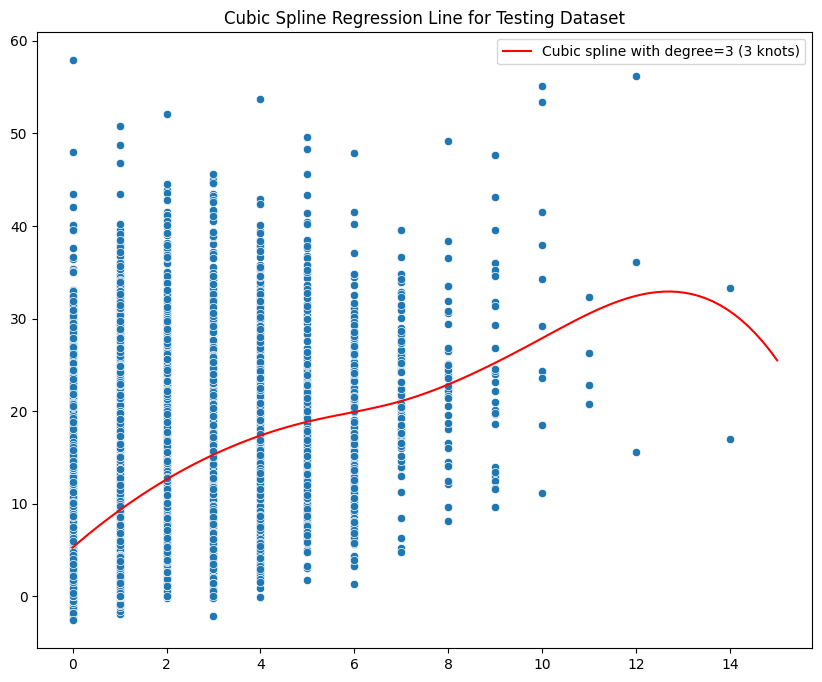

In [92]:
# Train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.3)

# Create spline	
from patsy import dmatrix
from sklearn.metrics import mean_squared_error

transformed_x = dmatrix("bs(train, knots=(5,7,10), degree=3, include_intercept=False)",
                        {"train": X_train},return_type='dataframe')
import statsmodels.api as sm
cs = sm.GLM(y_train, transformed_x).fit()
pred_test = cs.predict(dmatrix("bs(test, knots=(5,7,10), include_intercept=False)",
                               {"test": X_test}, return_type='dataframe'))
rmse_test = mean_squared_error(y_test, pred_test, squared=False)
print("Accuracy for Cubic Spline on testing data is : ",rmse_test)
 
import numpy as np
plt.figure(figsize=(10,8))
xp = np.linspace(X_test.min(),X_test.max(), 100).reshape(-1, 1)
pred = cs.predict(dmatrix("bs(xp, knots=(5,7,10), include_intercept=False)", 
                          {"xp": xp}, return_type='dataframe'))
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten())
plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='red')
plt.legend()
plt.title("Cubic Spline Regression Line for Testing Dataset")
plt.show()

In [ ]:
# Trying to use cross validation to find optimal number of knots, but it's not working...

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from patsy import dmatrix
import numpy as np

# Model set up
X_single = model_data[["redzone"]].values
y = weekly1[["fantasy_points_ppr"]].values

# Split data for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a range of knot values
knot_values = [5, 7, 10, 15, 20]

# Perform cross-validation
for knots in knot_values:
    rmse_scores = []
    for train_index, val_index in kf.split(X_single):
        X_train, X_val = X_single[train_index], X_single[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create spline with current number of knots
        transformed_x_train = dmatrix(f"bs(train, knots={knots}, degree=3, include_intercept=False)",
                                      {"train": X_train.flatten()}, return_type='dataframe')
        transformed_x_val = dmatrix(f"bs(val, knots={knots}, include_intercept=False)",
                                    {"val": X_val.flatten()}, return_type='dataframe')
        cs = sm.GLM(y_train, transformed_x_train).fit()

        # Predict on validation set
        pred_val = cs.predict(transformed_x_val)

        # Calculate RMSE
        rmse = mean_squared_error(y_val, pred_val, squared=False)
        rmse_scores.append(rmse)

    # Average RMSE across folds
    avg_rmse = np.mean(rmse_scores)

    print(f"Number of Knots: {knots}, Average RMSE: {avg_rmse}")



In [ ]:
# Smoothing splines wont work either for now, but there's an example in linear_regression.ipynb

In [20]:
scaler = StandardScaler()

steps = dict(scaler=scaler)

In [81]:
X_train.shape

(21666, 1)

In [82]:
y_train.shape

(21666, 1)

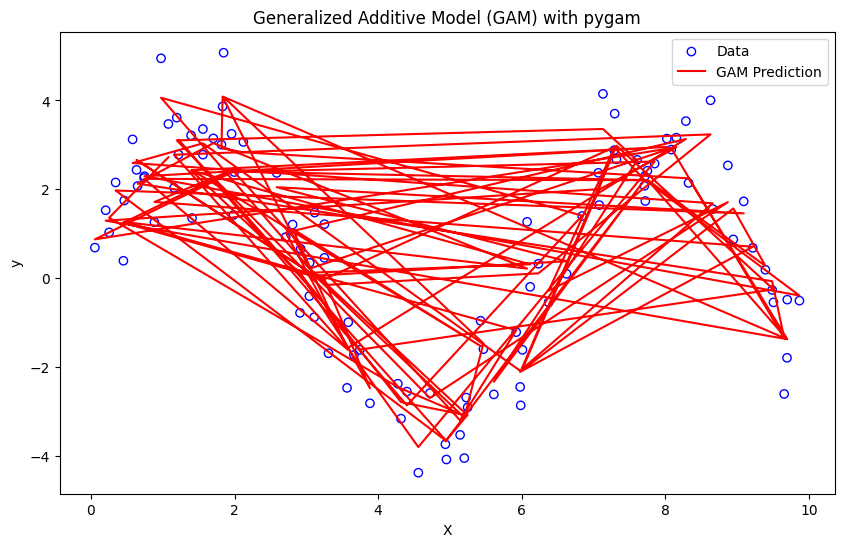

In [102]:
# Using GAMs
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Predictor variable
y = 3 * np.sin(X) + np.random.normal(0, 1, size=(100, 1))  # Response variable

# Fit a GAM with linear terms and a spline term
gam = LinearGAM(s(0, n_splines=20) + f(0))
gam.fit(X, y)

# Plot the fitted GAM
plt.figure(figsize=(10, 6))
plt.scatter(X, y, facecolor='none', edgecolor='blue', label='Data')
plt.plot(X, gam.predict(X), color='red', label='GAM Prediction')
plt.title('Generalized Additive Model (GAM) with pygam')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


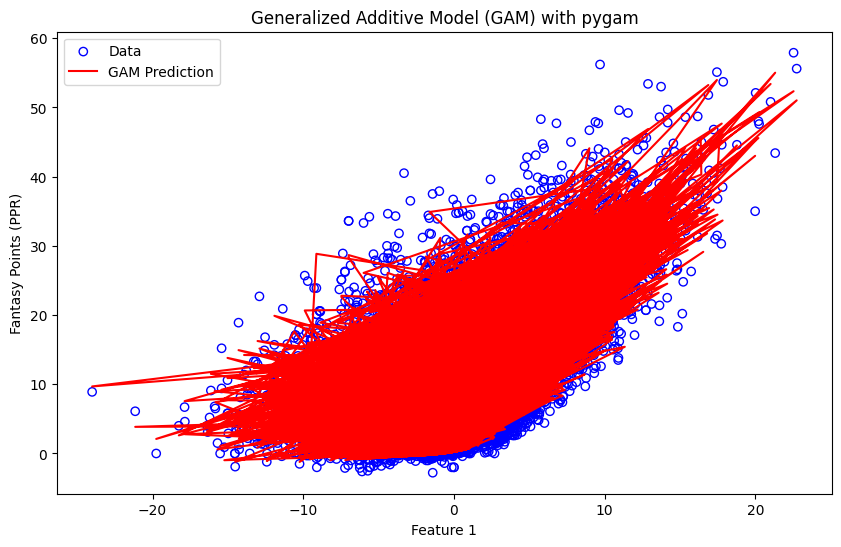

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# Assuming X is a 2D array (features) and y is the target variable
# Replace X and y with your actual data
X = model_data.values
y = weekly1[["fantasy_points_ppr"]].values

# Fit a GAM with a spline term for each feature
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4))  # Assuming you have 5 features
gam.fit(X, y)

# Plot the fitted GAM for the first feature (change index as needed)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y, facecolor='none', edgecolor='blue', label='Data')
plt.plot(X[:, 0], gam.predict(X), color='red', label='GAM Prediction')
plt.title('Generalized Additive Model (GAM) with pygam')
plt.xlabel('Feature 1')
plt.ylabel('Fantasy Points (PPR)')
plt.legend()
plt.show()


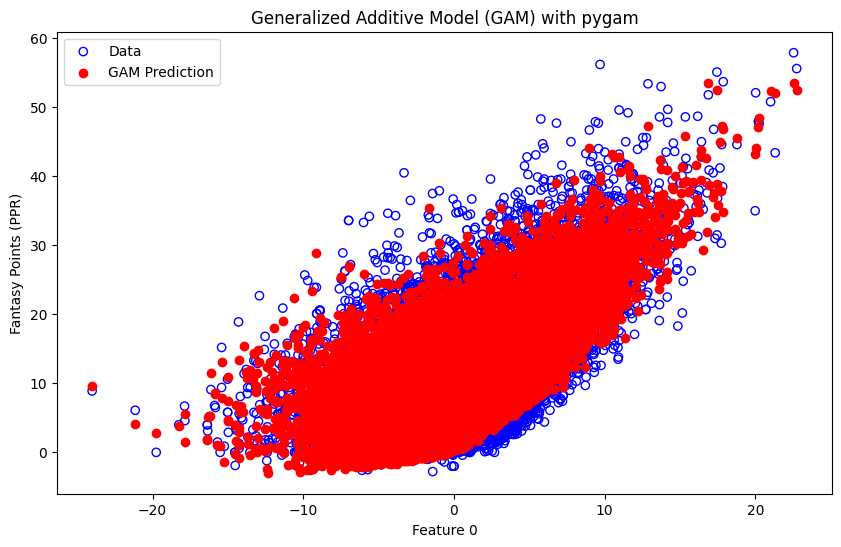

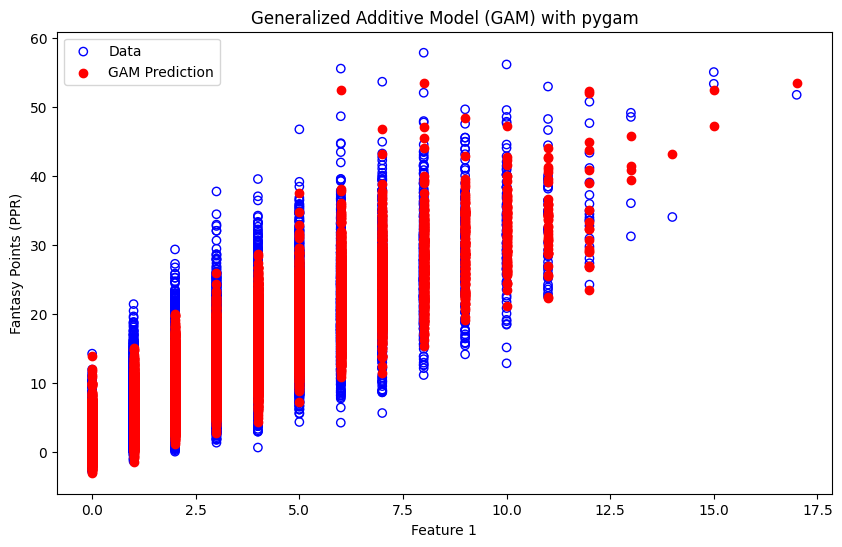

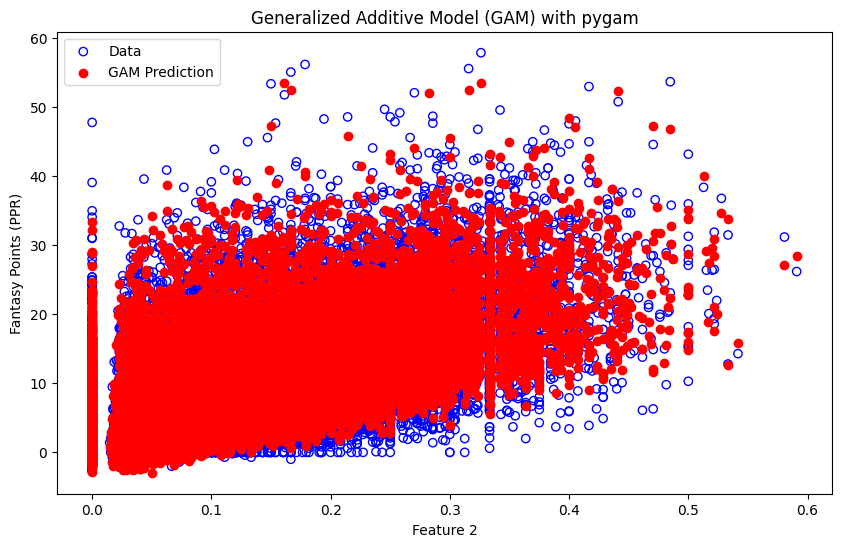

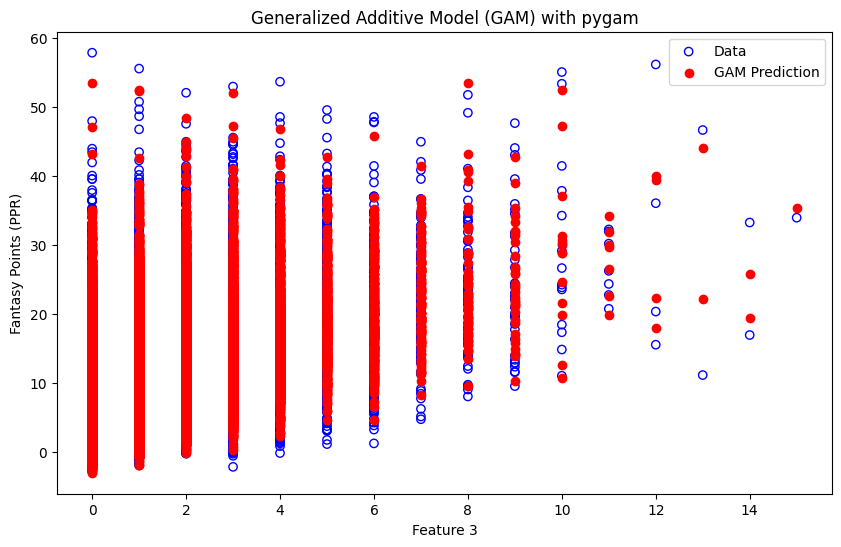

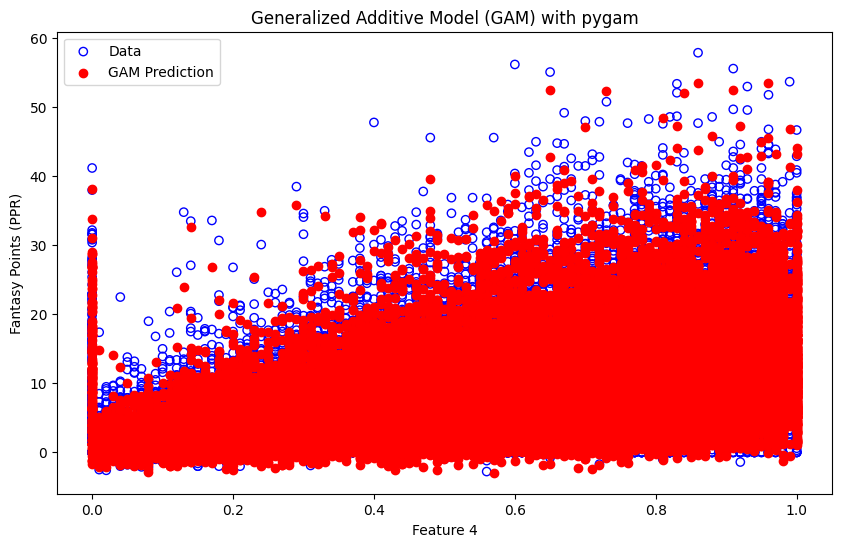

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# Assuming X is a 2D array (features) and y is the target variable
# Replace X and y with your actual data
X = model_data.values
y = weekly1[["fantasy_points_ppr"]].values

# Fit a GAM with a single spline term for all features
gam = LinearGAM(s(0, n_splines=20) + s(1, n_splines=20) + s(2, n_splines=20) + s(3, n_splines=20) + s(4, n_splines=20) + s(5, n_splines=20), fit_intercept=False)
gam.fit(X, y)

#Plot the fitted GAM
for i in range(5):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:,i], y, facecolor='none', edgecolor='blue', label='Data')
    plt.plot(X[:,i], gam.predict(X), color='red', label='GAM Prediction')
    plt.title('Generalized Additive Model (GAM) with pygam')
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Fantasy Points (PPR)')
    plt.legend()
    plt.show()



In [113]:
gam.score(X, gam.predict(X))

1.0

In [114]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     88.1468
Link Function:                     IdentityLink Log Likelihood:                                -94445.5176
Number of Samples:                        30952 AIC:                                           189069.3289
                                                AICc:                                          189069.8497
                                                GCV:                                                7.9614
                                                Scale:                                              7.9206
                                                Pseudo R-Squared:                                   0.8662
Feature Function                  Lam

ValueError: X data must have 6 features, but found 1

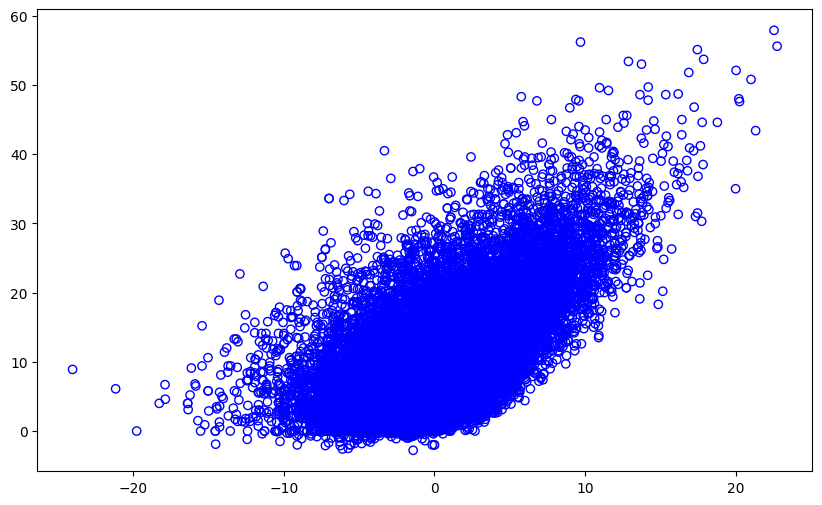

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# Assuming X is a 2D array (features) and y is the target variable
# Replace X and y with your actual data
X = model_data.values
y = weekly1["fantasy_points_ppr"].values

# Combine all features into a single spline term
combined_spline = s(0, n_splines=5) + s(1, n_splines=5) + s(2, n_splines=5) + s(3, n_splines=5) + s(4, n_splines=5) + s(5, n_splines=5)

# Fit a GAM with the combined spline term
gam = LinearGAM(combined_spline)
gam.fit(X, y)

# Plot the fitted GAM
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y, facecolor='none', edgecolor='blue', label='Data')
plt.plot(X[:, 0], gam.predict(X), color='red', label='GAM Prediction')
plt.title('Generalized Additive Model (GAM) with pygam')
plt.xlabel('Feature 1')
plt.ylabel('Fantasy Points (PPR)')
plt.legend()
plt.show()
